In [11]:
import numpy as np
from numpy.random import default_rng
import optimizers
import ct_utils
import skimage
import matplotlib.pyplot as plt
from ipywidgets import interactive
from IPython.display import display
import pywt

def todo():
    raise NotImplementedError("In dieser Zelle gibt es noch mindestens ein TODO!")

# Inverse Probleme: Statistische Perspektive

Mal angenommen, wir haben bereits einen großartigen, genauen Inversionsalgorithmus und damit haben wir eine Lösung $x^{\ast}$ aus $y^\varepsilon$ berechnet.
> Wie sicher können wir sein, dass $x^{\ast}$ eine repräsentative Lösung ist? 
> Wie groß sind die Fehler, die wir aufgrund der stochastischen Natur des Rauschens $\varepsilon$ gemacht haben könnten? 

Betrachten wir beispielsweise das folgende Beispiel, bei dem zwei unabhängige CT-Scans desselben Objekts durchgeführt werden:

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/lk/miniforge3/envs/akademie/lib/python3.10/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


  0%|          | 0/25 [00:00<?, ?it/s]

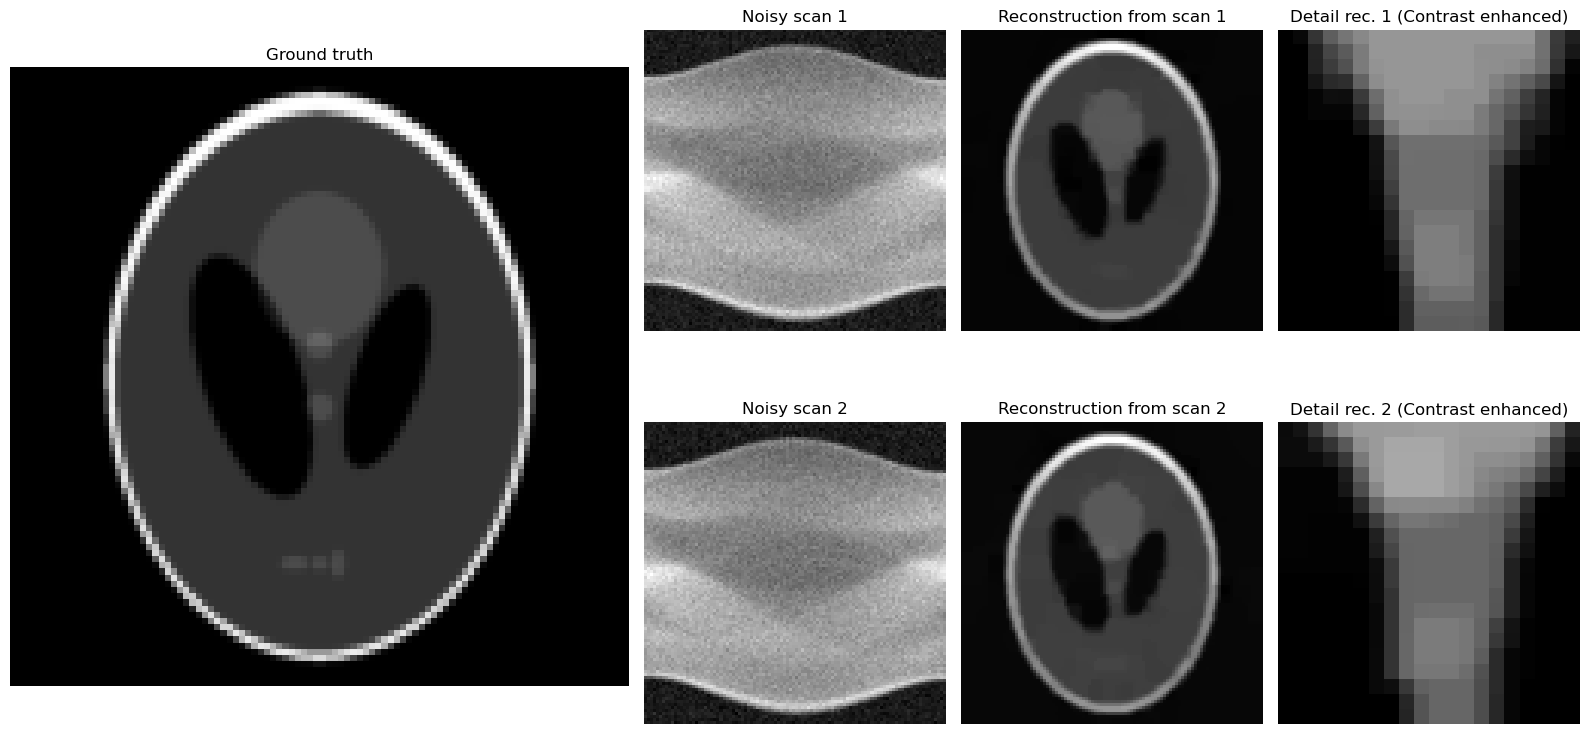

In [12]:
import matplotlib.gridspec as gridspec

rng = default_rng(2452)

dim = 100
x_gt = skimage.img_as_float(skimage.data.shepp_logan_phantom())
x_gt = skimage.transform.resize(x_gt, (dim, dim))

theta = np.linspace(0, 180, endpoint=False, num=dim)
A = ct_utils.Radon(theta)

# Clean data
y_clean = A(x_gt)

# Zwei verschiedene Instanzen von noise
sigma = 0.01
noise1 = sigma * rng.normal(size=y_clean.shape)
noise2 = sigma * rng.normal(size=y_clean.shape)
y1 = y_clean + noise1
y2 = y_clean + noise2

# compute the minimizer
mu_tv = 0.005
opt1 = optimizers.split_Bregman_TV(
    A,
    y1,
    np.zeros(y_clean.shape),
    1,
    mu_tv,
    max_it=25,
    verbosity=0,
    energy_fun=lambda x: np.sqrt(np.sum((A(x) - y1) ** 2)) / dim**2,
)
opt2 = optimizers.split_Bregman_TV(
    A,
    y2,
    np.zeros(y_clean.shape),
    1,
    mu_tv,
    max_it=25,
    verbosity=0,
    energy_fun=lambda x: np.sqrt(np.sum((A(x) - y2) ** 2)) / dim**2,
)
rec1 = opt1.solve()
rec2 = opt2.solve()

# plot results
fig = plt.figure(tight_layout=True, figsize=(16, 8))
gs = gridspec.GridSpec(2, 5)
ax = [fig.add_subplot(gs[:, 0:2])]
for i in range(6):
    ax.append(fig.add_subplot(gs[i % 2, 2 + i // 2]))
ax[0].imshow(x_gt, cmap="gray", vmin=0, vmax=1), ax[0].set_title("Ground truth")
ax[1].imshow(y1, cmap="gray"), ax[1].set_title("Noisy scan 1")
ax[2].imshow(y2, cmap="gray"), ax[2].set_title("Noisy scan 2")
ax[3].imshow(rec1, cmap="gray"), ax[3].set_title("Reconstruction from scan 1")
ax[4].imshow(rec2, cmap="gray"), ax[4].set_title("Reconstruction from scan 2")
(
    ax[5].imshow(
        rec1[dim // 2 - 10 : dim // 2 + 10, dim // 2 - 10 : dim // 2 + 10],
        cmap="gray",
        vmin=0,
        vmax=0.5,
    ),
    ax[5].set_title("Detail rec. 1 (Contrast enhanced)"),
)
(
    ax[6].imshow(
        rec2[dim // 2 - 10 : dim // 2 + 10, dim // 2 - 10 : dim // 2 + 10],
        cmap="gray",
        vmin=0,
        vmax=0.5,
    ),
    ax[6].set_title("Detail rec. 2 (Contrast enhanced)"),
)

for axes in ax:
    axes.axis("off")

Wir müssen also der Verteilung der möglichen Lösungen $x$, dem Rauschen $\varepsilon$ und den beobachteten Daten $y$ eine statistische Bedeutung zuweisen. Wir nehmen an, dass sowohl $x$ als auch $\varepsilon$ Instanzen von Zufallsvariablen mit bestimmten Wahrscheinlichkeitsverteilungen sind. Für die marginale Verteilung möglicher Lösungen schreiben wir $x \sim \pi_0$. Die Wahrscheinlichkeit, $y = A(x)+\varepsilon$ zu beobachten, wenn $x$ gegeben ist, wird mit $\pi_{y|x}$ bezeichnet.

$\pi_0$ wird als **Prior-Verteilung** bezeichnet und kodiert Vorabinformationen, Annahmen oder Überzeugungen über die mögliche Natur unserer Rekonstruktion $x$. Nehmen wir an, dass $\pi_0$ eine Wahrscheinlichkeitsdichtefunktion (pdf) $p_0(x)$ hat.

Die Dichte $p(\cdot|x)$ der Verteilung $\pi_{y|x}$ wird als **Likelihood** bezeichnet.

Sobald wir eine Beobachtung $y$ machen, hat gemäß dem **Bayes-Gesetz** die **posteriori-Verteilung** von $x$ nach dem Betrachten von $y$ die Dichte
$$ p(x|y) = \frac{p(y|x)p_0(x)}{p(y)} \propto p(y|x) p_0(x). $$

### Prior-Verteilung
Beispiele
- Wenn wir davon ausgehen, dass unsere Lösung $x$ nahe an einem a priori bekannten Wert $\hat x$ liegen sollte, könnte unsere Prior-Verteilung etwa wie folgt aussehen: $p_0(x) \propto \exp(-\frac{1}{2\sigma^2}||x-\hat x||_2^2)$. Die Normalisierungskonstante $Z$ stellt sicher, dass $p_0$ eine gültige Wahrscheinlichkeitsdichtefunktion ist. Wir lassen sie von nun an weg und schreiben „$\propto$” für Proportionalität. Gemäß dieser Prior-Dichte werden Werten, die näher an $\hat x$ liegen, größere Wahrscheinlichkeitswerte zugewiesen, da sie als wahrscheinlicher angenommen werden.
- Wenn wir davon ausgehen, dass $x$ wahrscheinlich nur wenige Kanten/Kontrastsprünge aufweist, könnten wir eine Prior-Verteilung wie $p_0(x) \propto \exp(-\mathrm {TV}(x)) = \exp(- \lVert \nabla x \rVert_1)$ wählen.
- Ganz allgemein kann man mit einer passenden Regularisierungs-Funktion $J$ den *Gibbs-Prior* $ p_0(x) \propto \exp(-J(x))$ verwenden.

### Likelihood
- Gaußsche (unabhängige, homoskedastische) Fehler $\varepsilon \sim \mathrm{N}(0,I)$ führen zur Likelihood Dichte der Form $ p(y|x) \propto \exp(- ||y-A(x)||_2^2 ) $.
- Wenn die beobachtete Variable $y$ einer Poisson-Verteilung $y \sim \mathrm{Pois}(A(x))$ folgt, dann gilt $p(y|x) \propto \frac 1{y!} \exp(-A(x)) A(x)^y $ für alle $y \in \mathbb{N}$.

## 1D-Beispiel
Ganz simples Beispiel: Wir wollen die Zahl $x\in \mathbb{R}$ schätzen, haben aber nur eine Messung $y = a \cdot x + \varepsilon$ mit $a = 4$ und etwas zufälligem Rauschen $\varepsilon$ (das ist nicht wirklich ein inverses Problem).

Wir nehmen an, dass das Rauschen wie $\varepsilon \sim \mathrm N(0,\sigma^2)$ verteilt ist und eine Prior-Verteilung $x \sim \mathrm N(\mu_{0}, 1)$ hat.
Die slider sollen ein Gefühl dafür geben, wie sich die Posterior-Verteilung in Abhängigkeit von prior und likelihood verändert.

In [13]:
def plot_1dposterior(sigma, mu0, y):
    fig,ax = plt.subplots(1, 3, figsize=(15,5))
    # prior
    t = np.linspace(-5,5,500)
    ax[0].plot(t,1/np.sqrt(2*np.pi)*np.exp(-(t-mu0)**2/2))
    ax[0].set_title('Prior distribution p(x)')

    # likelihood
    a = 4               # the "forward model"
    ax[1].plot(t,1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(y-a*t)**2/(2*sigma**2)))
    ax[1].set_title('Likelihood function p(y|x)')

    # posterior distribution
    ax[2].plot(t,np.exp(-(t-mu0)**2/2 -(y-a*t)**2/(2*sigma**2)))
    ax[2].scatter(1/(1+a**2/sigma**2)*(mu0 + a/sigma**2 * y),0,c='r',marker='x')
    ax[2].set_yticks([])
    ax[2].set_title('Posterior distribution p(x|y)')

interactive_plot = interactive(plot_1dposterior, sigma = (0.1,4.0,0.1), mu0 = (-2.0,2.0,0.1), y = (-10.0,10.0,0.1))
display(interactive_plot)

interactive(children=(FloatSlider(value=2.0, description='sigma', max=4.0, min=0.1), FloatSlider(value=0.0, de…

## Bewertung der Posterior-Verteilung
Betrachten wir ein einfaches Beispiel **Denoising**, bei dem wir ein verrauschtes Bild
$$ y = x + \varepsilon $$
messen (also $A = Id$). Die Fehler $\varepsilon$ sind wieder als gaußverteilt mit Mittelwert Null und Standardabweichung $\sigma$ verteilt.

Um zu regularisieren, nehmen wir an, dass $x$ in einer bestimmten Basis $D$ dünnbesetzt ist, die entsprechende Gibbs-Prior-Verteilung hat die Dichte
$$ p_0(x) \propto \exp(-|| Dx ||_1). $$

Wir möchten einige Statistiken des Posteriors berechnen:
- Den posterior mean $\mu_{x|y} := \mathbb E_{x|y}[x]$
- Die posterior (pixelweise) variance $ \sigma^2_{x|y} := \mathbb E_{x|y}[(x- \mu_{x|y})^2] $

Um $\mu_{x|y}$ und $\sigma^2_{x|y}$ zu berechnen, müssen wir Stichproben aus der dem posterior $\pi_{x|y}$ ziehen. Wir verwenden einen simplen Markov-Ketten Sampling-Algorithmus, der fast wie gradient descent aussieht, aber zusätzlich Rauschen einfügt. Die Iteration ist
$$ \begin{array}{l} \xi_{k+1} \sim \mathrm N (0, I), \\
X_{k+1} = X_k - \eta \nabla f(X_k) + \sqrt{2\eta} \xi_{k+1}.
\end{array} $$
Hier ist $ f $ die negative Log-Dichte der Posterior-Verteilung: $f(x) = -\log p_{x|y}(x)$.

**Aufgaben**
Der folgende Code berechnet den Minimierer $\hat x = \min f(x)$, initialisiert $X_0 = \hat x$ und führt dann den oben genannten Langevin-Sampling-Algorithmus aus.
- Was wird in ax[0,2] angezeigt?
- Nehmt drei beliebige Samples $X^k$ (für irgendwelche $k$) und plottet sie in ax[1,0], ax[1,1] und ax[1,2]. Wie unterscheiden sich die Stichproben qualitativ von $\hat x$ und $\mu_{x|y}$?
- Wie werden  $\sigma^2_{x|y}$?

$$ \sigma^2_{x|y} \approx \frac 1 N \sum_{k=1}^N X_k^2 - \left(\frac 1 N \sum_{k=1}^N X_k\right)^2 $$

  0%|          | 0/1 [00:00<?, ?it/s]

NotImplementedError: In dieser Zelle gibt es noch mindestens ein TODO!

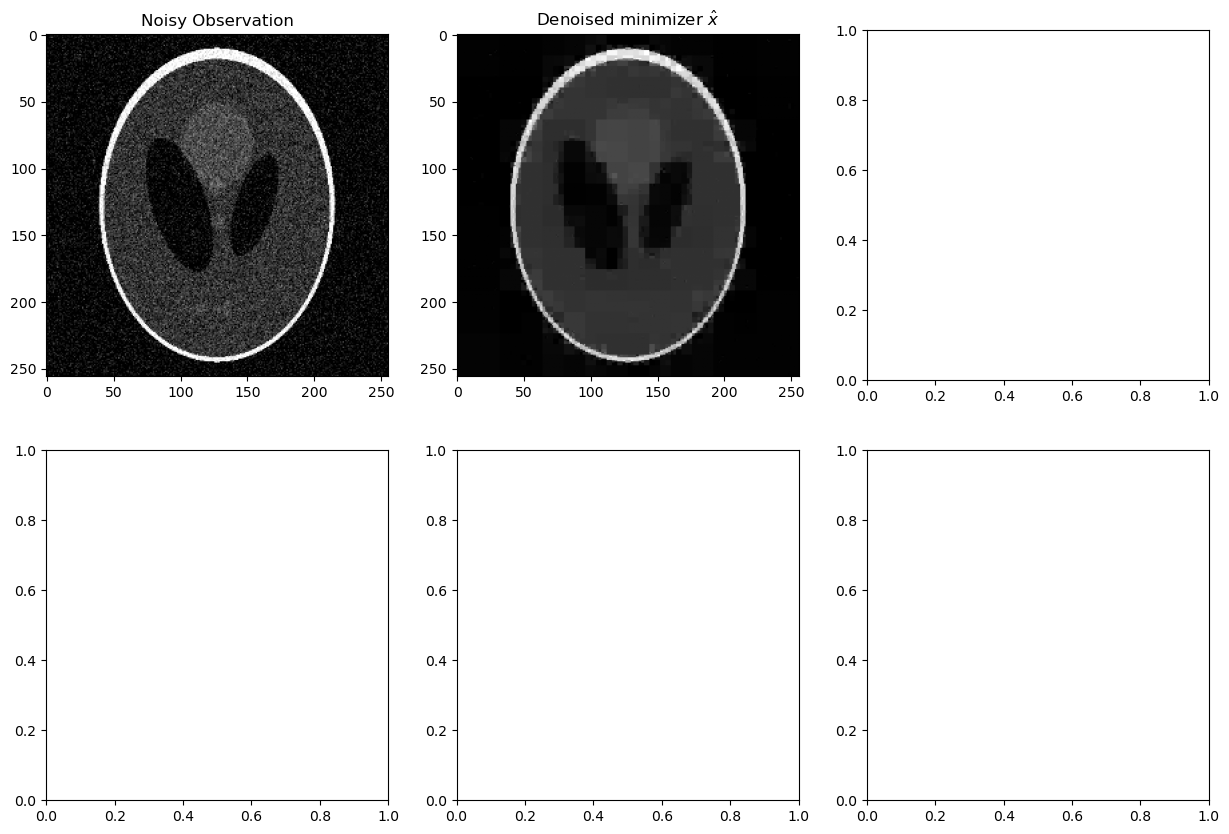

In [15]:
sigma = 0.1
lamda = 30
t = sigma**2

dim = 256
x_gt = skimage.img_as_float(skimage.data.shepp_logan_phantom())
x_gt = skimage.transform.resize(x_gt, (dim, dim))

wl = pywt.Wavelet("haar")
y = x_gt + sigma * rng.normal(size=(dim, dim))
opti = optimizers.ista_wavelets(
    ct_utils.Identity(),
    np.zeros_like(x_gt),
    y,
    wave=wl,
    eta=1,
    lamda=lamda * sigma**2,
    verbosity=0,
    max_it=1,
)
opti.solve()
x = np.copy(opti.x)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(y, cmap="gray", vmin=0, vmax=1)
ax[0, 0].set_title("Noisy Observation")
ax[0, 1].imshow(x, cmap="gray", vmin=0, vmax=1)
ax[0, 1].set_title("Denoised minimizer $\hat x$")

n_samples = 1000
log_post_dens = np.zeros((n_samples,))

running_sum = np.zeros_like(x)
running_squared_sum = np.zeros_like(x)
for i in range(n_samples):
    # Langevin sampling step
    z = x - t / sigma**2 * (x - y) + np.sqrt(2 * t) * rng.normal(size=(dim, dim))
    wv_coeffs, slices = pywt.coeffs_to_array(
        pywt.wavedec2(z, wavelet=wl, mode="periodization")
    )
    wv_coeffs_shr = optimizers.soft_shrinkage(wv_coeffs, lamda * t)
    x = pywt.waverec2(
        pywt.array_to_coeffs(wv_coeffs_shr, slices, output_format="wavedec2"),
        wavelet=wl,
        mode="periodization",
    )

    todo() # Plotte ein paar der Samples in ax[1,0], ax[1,1] und ax[1,2]

    running_sum += x
    running_squared_sum += x**2

    log_post_dens[i] = 0.5 / sigma**2 * np.linalg.norm(
        x - y
    ) ** 2 + lamda * np.linalg.norm(wv_coeffs_shr, ord=1)


ax[0, 2].imshow(running_sum / n_samples, cmap="gray", vmin=0, vmax=1)
ax[0, 2].set_title(todo())

# ax[1, 1].imshow(
#     np.log((running_squared_sum / n_samples) - (running_sum / n_samples) ** 2),
#     cmap="gray",
# )
# ax[1,1].set_title("Pixelweise Varianz")